---
title: Classification loss function as comparing 2 vectors
from: markdown+emoji
author: "Dien-Hoa Truong"
date: 2020-05-01
categories: [deeplearning]

---

Walking through a simple Dot-Product to Cross-Entropy then finally a completely new loss function

![Dot-Product](https://mathinsight.org/media/image/image/dot_product_projection.png)


## Introduction

In this blog post, I will try to explain the Classification Loss function from the perspective of comparing 2 vectors. We'll start with the most simple loss: the dot-product of 2 vectors, with a simple modification we'll have the Cross-Entropy Loss and then try to beat the result of Cross-Entropy with our one.

## Review the topic

### How to compare 2 vectors

A vector is just an arrow with a direction and length. So for the binary classification problem, we have an output vector that has 2 elements and sum up to 1. [p1, p2] and p1+p2 = 1

Imagine we want our target vector to be [0,1]. The worst prediction is [0,1] and a good prediction could be [0.99,0.01]

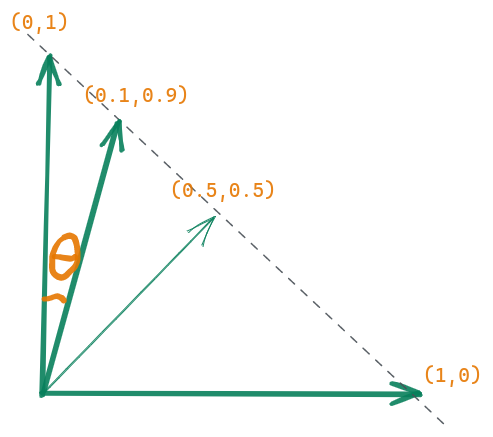

We notice that $cos(\theta)$ for $\theta$ from 0&deg; to 90&deg; decreases strictly from 1 to 0 (from the best to worst prediction) so it can be an indicator for our prediction (And it exists - cosine similarity). Any function that has value increasing/decreasing strictly from the best prediction to the worst prediction can be considered a loss function

The dot-product has some relevance to the cosine mentioned above. The dot-product from a geometrical point of view is the projection of a vector to the direction of another vector and multiplying them both. And the projection is calculated by multiplying the cosine of the angle between these 2 vectors. But in this simple case, the projection is just the y value if our predicted vector is (x,y) and the target vector is (0,1). And the **y value decreases strictly from 1 to 0 from the vector (1,0) to vector (0,1)** . So the dot-product can also be a candidate for our loss function too


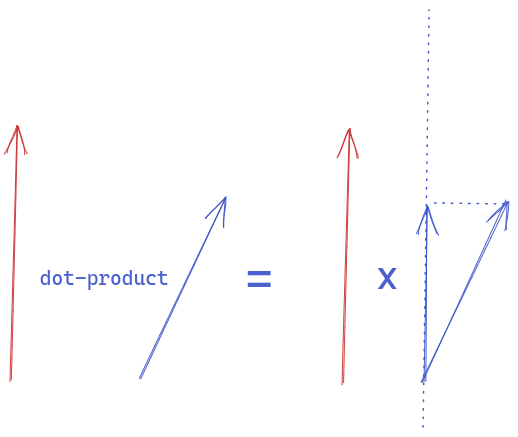

In the multiclass classification problem with the target vector encoded by one-hot vector (Vector has just one 1 value and 0 for all others position). The dot-product calculation is very simple. Taking the value in the predicted vector at its position in the target vector, we have 1. (Dot-product in algebra is just the sum of the element-wise multiplication)

In [ ]:
v1 = np.array([0,1,0,0]) # target vector 
v2 = np.array([0.2,0.3,0.1,0.4]) # predicted vector
print(sum(v1*v2))

0.3


For the Cross-Entropy Loss Function, instead of multiplying the predicted vector, we multiply the logarithm of the predicted vector

In [ ]:
print(sum(v1*np.log(v2)))
print(np.log(0.3))

-1.2039728043259361
-1.2039728043259361


In the next section, we will experiment the dot-product loss function, the cross-entropy loss function and try to invent of own loss function by changing the function applying the the predicted vector (like logarithm in the case of Cross-Entropy)

# Compare Different Loss Functions

In this part, we will experiment with our dot-product loss function, compare its performance with the famous cross-entropy loss function and finally, try to invent a new loss function that is comparable to the cross-entropy loss function.

The experiments use data from the Oxford-IIIT Pet Dataset and the resnet18 model from the fastai library

## Getting Data

This part is simply for data preparation. Putting all the images and their labels into the corresponding dataloader

In [ ]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)
items = get_image_files(path/'images')

def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

labeller = RegexLabeller(pat=r"(.+)_\d+.jpg")

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y = Pipeline([lambda x: getattr(x,'name'), labeller]),
                    item_tfms=Resize(224), 
                    batch_tfms=aug_transforms(),
                    )

In [ ]:
dls = pets.dataloaders(path/'images')

In [ ]:
dls.c # number of categories in this dataset

37

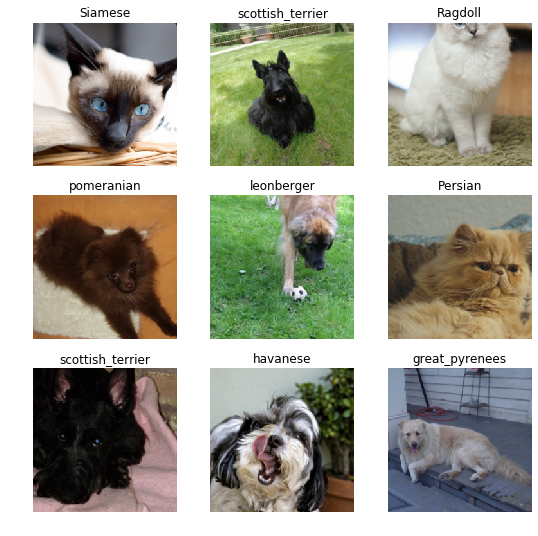

In [ ]:
dls.show_batch()

## Experimenting

All our loss functions will have two parts. The first part is the softmax function - scaling our output to [0,1]. The second part is how we penalize our prediction - high loss if the predicted vector is far from the target.

### Cross_Entropy loss

In [ ]:
def softmax(x): return x.exp() / (x.exp().sum(-1)).unsqueeze(-1)
def nl(input, target): return -input[range(target.shape[0]), target].log().mean()
def our_cross_entropy(input, target):
    pred = softmax(input)
    loss = nl(pred, target)
    return loss

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=our_cross_entropy, metrics=error_rate)

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.621736,0.353662,0.110284,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.535891,0.278063,0.092016,00:41


### Dot Product Loss

This is a negative dot-production loss function because we multiply the result by -1 to make it increase from best to worst prediction

In [ ]:
def dot_product_loss(input, target):
    pred = softmax(input)
    return -(pred[range(target.shape[0]), target]).mean()

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=dot_product_loss, metrics=error_rate)

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,-0.485698,-0.798422,0.179973,00:31


epoch,train_loss,valid_loss,error_rate,time
0,-0.778386,-0.841704,0.144790,00:42


Wow ! despite the simplicity of the dot-product loss function, we got not so bad result (0.14) after 2 epochs. Our dataset has 37 categories of pets and a random prediction will give us the error rate (1-1/37)=0.97. Can we do it better ?

### The difference between cross-entropy loss and dot-product loss

How these 2 loss functions penalize the prediction is described as below. The target vector is always [0,1]

In [ ]:
x = np.linspace(0.01,0.99,100) # the predicted vector at index 2
y_dot_product = -x
y_cross_entropy = -np.log(x)

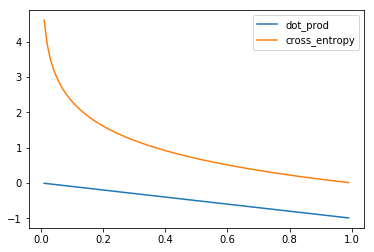

In [ ]:
plt.plot(x, y_dot_product, label='dot_prod')
plt.plot(x, y_cross_entropy, label='cross_entropy')
plt.legend()
plt.show()

From the plot, we can see that the cross-entropy function penalizes more when we have a wrong prediction (kind of exponential shape)

In the next section, we will try others loss functions but the core idea is still based on the dot-product loss function. 

### Inverse Loss

Instead of multiplying by -1, we can inverse the predicted value to make it increase from best to worst prediction. Let's see the plot below:

In [ ]:
y_inv = 1/x

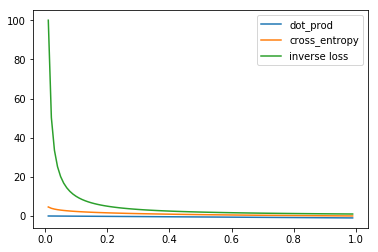

In [ ]:
plt.plot(x, y_dot_product, label='dot_prod')
plt.plot(x, y_cross_entropy, label='cross_entropy')
plt.plot(x, y_inv, label='inverse loss')

plt.legend()
plt.show()

The inverse loss penalizes may be too much compared to the 2 previous ones, no tolerance at all might be not so good. But let's try it anyway

In [ ]:
def inverse_loss(input, target):
    pred = softmax(input)
    return (1/((pred[range(target.shape[0]), target]))).mean()

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=inverse_loss, metrics=error_rate)

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,447.855957,11.976704,0.466170,00:19


epoch,train_loss,valid_loss,error_rate,time
0,50.260994,5.570698,0.258457,00:24


Ok, we have s worst result. But with this idea, we can easily tune the loss function. We can power the denominator with a value < 1 to decrease the penalization. For example 0.2

In [ ]:
y_inv_tuning = 1/(x**0.2)

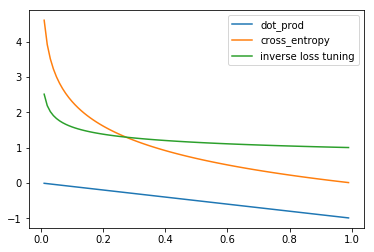

In [ ]:
plt.plot(x, y_dot_product, label='dot_prod')
plt.plot(x, y_cross_entropy, label='cross_entropy')
plt.plot(x, y_inv_tuning, label='inverse loss tuning')

plt.legend()
plt.show()

Let's try this new loss function

In [ ]:
def inverse_loss_tunning(input, target):
    pred = softmax(input)
    return (1/((pred[range(target.shape[0]), target]).pow(0.2))).mean()

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=inverse_loss_tunning, metrics=error_rate)

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.583183,1.099432,0.125846,00:31


epoch,train_loss,valid_loss,error_rate,time
0,1.174570,1.070881,0.091340,00:42


We get not so different error rate: 0.091 compared to 0.092 of the cross-entropy loss function. 